In [2]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [80]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import MultivariateNormal

from nf.flows import FCNN

import matplotlib.pyplot as plt
from IPython.display import clear_output
import xgboost as xgb

%matplotlib inline

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class NormalizingFlowModel(nn.Module):

    def __init__(self, dim, prior, flows):
        super().__init__()
        self.dim = dim
        self.prior = prior
        self.flows = nn.ModuleList(flows)

    def forward(self, x):
        m, _ = x.shape
        log_det = torch.zeros(m).to(x.device)
        for flow in self.flows:
            x, ld = flow.forward(x)
            log_det += ld
        z, prior_logprob = x, self.prior.log_prob(x)
        return z, prior_logprob, log_det

    def backward(self, z):
        m, _ = z.shape
        log_det = torch.zeros(m).to(z.device)
        for flow in self.flows[::-1]:
            z, ld = flow.backward(z)
            log_det += ld
        x = z
        return x, log_det

    def sample(self, n_samples):
        z = self.prior.sample((n_samples,self.dim))
        if z.dim() != 2: z = self.prior.sample((n_samples,))
        x, _ = self.backward(z)
        return x

In [19]:
class MAF(nn.Module):
    """
    Masked auto-regressive flow.

    [Papamakarios et al. 2018]
    """
    def __init__(self, dim, hidden_dim = 8, base_network=FCNN):
        super().__init__()
        self.dim = dim
        self.layers = nn.ModuleList()
        self.initial_param = nn.Parameter(torch.Tensor(2))
        for i in range(1, dim):
            self.layers += [base_network(i, 2, hidden_dim)]
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.uniform_(self.initial_param, -np.sqrt(0.5), np.sqrt(0.5))

    def forward(self, x):
        z = torch.zeros_like(x)
        log_det = torch.zeros(z.shape[0]).to(x.device)
        for i in range(self.dim):
            if i == 0:
                mu, alpha = self.initial_param[0], self.initial_param[1]
            else:
                out = self.layers[i - 1](x[:, :i])
                mu, alpha = out[:, 0], out[:, 1]
            z[:, i] = (x[:, i] - mu) / torch.exp(alpha)
            log_det -= alpha
        return z.flip(dims=(1,)), log_det

    def backward(self, z):
        x = torch.zeros_like(z)
        log_det = torch.zeros(z.shape[0]).to(z.device)
        z = z.flip(dims=(1,))
        for i in range(self.dim):
            if i == 0:
                mu, alpha = self.initial_param[0], self.initial_param[1]
            else:
                out = self.layers[i - 1](x[:, :i])
                mu, alpha = out[:, 0], out[:, 1]
            x[:, i] = mu + torch.exp(alpha) * z[:, i]
            log_det += alpha
        return x, log_det

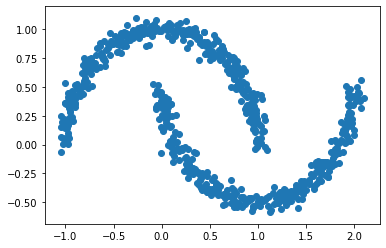

In [54]:
X, _ = make_moons(1000)
n, dim = X.shape
X += np.random.normal(0, 0.05, X.shape)
X = X.astype(np.float32)
X_train, X_test = X[: n * 7 // 10], X[n * 7 // 10: ]

plt.scatter(X_train[:, 0], X_train[:, 1])

In [55]:
np.max(X_train[:, 0])

2.0946734

In [56]:
X_train_tensor = torch.from_numpy(X_train).to(device)
X_test_tensor = torch.from_numpy(X_test).to(device)

In [66]:
prior = MultivariateNormal(torch.zeros(dim).to(device), torch.eye(dim).to(device))
model = NormalizingFlowModel(dim, prior, [MAF(dim), MAF(dim)]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [67]:
epoches = 1000
metrics = []

In [68]:
X_test_tensor.dtype

torch.float32

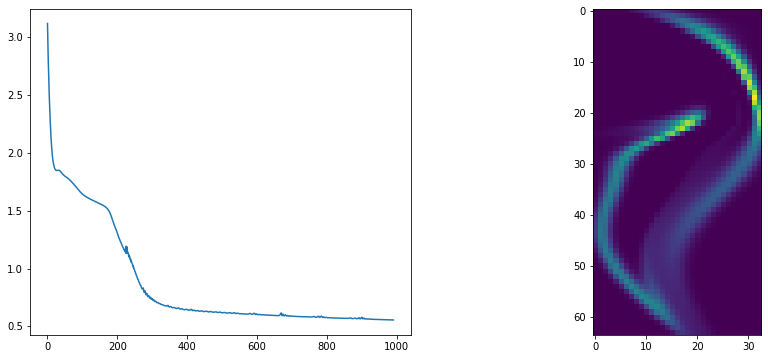

In [69]:
for epoch in range(len(metrics), epoches):
    model.train()
    optimizer.zero_grad()
    z, logp_z, log_det = model(X_train_tensor)
    logp_x = logp_z + log_det
    loss = -torch.mean(logp_x)
    loss.backward()
    optimizer.step()
    metrics.append(loss.mean().detach().cpu())

    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            X_val = np.transpose(np.dstack(np.meshgrid(
                np.arange(np.min(X_test[:, 0]), np.max(X_test[:, 0]), 0.05),
                np.arange(np.min(X_test[:, 1]), np.max(X_test[:, 1]), 0.05),
            )), axes=[1, 0, 2]).astype(np.float32)
            
            z, logp_z, log_det = model(
                torch.from_numpy(X_val.reshape(-1, 2)).to(device),
            )
            log_probs = logp_z + log_det
            log_probs = log_probs.detach().cpu().numpy()
            
        probs = np.exp(log_probs).reshape(X_val.shape[0], X_val.shape[1])

        clear_output(False)
        fig, axs = plt.subplots(1, 2, figsize=(15, 6))

        axs[0].plot(np.arange(len(metrics)), metrics)
        axs[1].imshow(probs)

    plt.show()

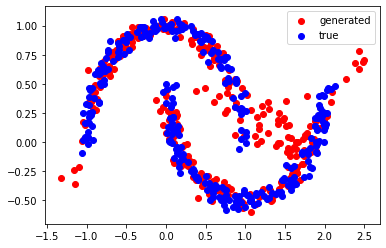

In [98]:
X_generated = model.sample(len(X_test)).detach().cpu().numpy()
y_generated = np.zeros(len(X_generated))
y_test = np.ones(len(X_test))

X_clf = np.vstack([X_test, X_generated])
y_clf = np.hstack([y_test, y_generated])

plt.scatter(X_clf[y_clf==0][:, 0], X_clf[y_clf==0][:, 1], c='red', label='generated')
plt.scatter(X_clf[y_clf==1][:, 0], X_clf[y_clf==1][:, 1], c='blue', label='true')

plt.legend()

In [99]:
X_clf.shape, y_clf.shape

((600, 2), (600,))

In [75]:
params = dict(
    max_depth=5,
    n_estimators=100,
    learning_rate=0.1,
    min_child_weight=50,
    n_jobs=4
)
xgb_model = xgb.XGBClassifier(**params)

In [ ]:
xgb_model.fit(
    X=cls_train[dlls + features].values,
    y=cls_train['IsGenerated'].values.astype('int32'),
    sample_weight=cls_train[weight_filed]
)

In [73]:
model.eval()
with torch.no_grad():
    z, logp_z, log_det = model(X_test_tensor)
    log_probs = logp_z + log_det
    log_probs = log_probs.detach().cpu().numpy()
np.exp(log_probs)

array([2.15570021e+00, 8.51000026e-02, 8.79709303e-01, 7.94884503e-01,
       1.82042789e+00, 6.62808120e-01, 3.15943420e-01, 1.44438660e+00,
       1.52643585e+00, 1.90970138e-01, 8.77812147e-01, 8.91551912e-01,
       3.35627090e-04, 1.06136882e+00, 3.54144841e-01, 1.75523591e+00,
       1.03051221e+00, 8.97478044e-01, 1.73104441e+00, 1.15626609e+00,
       7.79561698e-01, 1.38287568e+00, 4.89687860e-01, 9.47735846e-01,
       1.11285186e+00, 1.61176670e+00, 2.32500821e-01, 1.34452850e-01,
       4.40781921e-01, 1.92537293e-01, 3.86678129e-01, 5.03889143e-01,
       4.53159988e-01, 6.05910242e-01, 8.33416045e-01, 6.79364264e-01,
       2.96629190e-01, 6.98056281e-01, 9.61500347e-01, 1.04497278e+00,
       5.87734342e-01, 3.17794263e-01, 1.02810729e+00, 3.82516772e-01,
       1.22545175e-01, 1.29262835e-01, 6.71341121e-01, 7.84181714e-01,
       3.00783068e-01, 1.57165349e+00, 9.28771973e-01, 2.14697272e-02,
       2.00667202e-01, 4.87694710e-01, 8.23843658e-01, 1.86962232e-01,
      